In [6]:
#READ DATA FROM PREPROCESSED FILE
import pandas as pd
#CHANGE THE PATH TO THE FOLDER WHERE YOU STORE DATA
df = pd.read_csv('/Users/phuong/Documents/JBI_paper/Data_files/Main_Data/All_Papers_Preprocessed.csv',encoding ='latin1')
df.head()

,PMID,Article Title,Abstract,Publication Type,Methods Section,First Label,Second Label,Third Label
0,8646822,A kinetic and dynamic study of oral alprazolam...,To assess the possible involvement of CYP3A4 i...,Clinical Trial ;Journal Article ;Randomized Co...,methods subjects twelve unrelated healthy male...,DDI Clinical Trial,RCT DDI Clinical Trial,RCT DDI Clinical Trial
1,8453848,A potentially hazardous interaction between er...,Interaction between erythromycin and midazolam...,Clinical Trial ;Journal Article ;Randomized Co...,material and methods study design orally admin...,DDI Clinical Trial,RCT DDI Clinical Trial,RCT DDI Clinical Trial
2,23210726,A semi-mechanistic absorption model to evaluat...,The aim of this study was to develop a PK/PD m...,Journal Article ;Randomized Controlled Trial ;...,methods ten healthy male volunteers randomized...,DDI Clinical Trial,RCT DDI Clinical Trial,RCT DDI Clinical Trial
3,11936570,A study of the interaction potential of azithr...,Atorvastatin is a common option among the HMG-...,"Clinical Trial ;Clinical Trial, Phase I ;Compa...",materials and methods this randomized open lab...,DDI Clinical Trial,RCT DDI Clinical Trial,RCT DDI Clinical Trial
4,1387301,Absolute bioavailability of clarithromycin aft...,The absolute bioavailability of clarithromycin...,Clinical Trial ;Comparative Study ;Journal Art...,clarithromycin new 14 membered macrolide antim...,PK Trial,Non-polymorphic enzyme/transport PK Trial,Non-polymorphic enzyme/transport PK Trial


In [7]:
#GENERATED LABELS FOR THE DATA
from io import StringIO

col = ['Article Title','Abstract','Methods Section','First Label','Second Label',"Third Label"]
df = df[col]

#generate categorize_id level 1 based on First Label
df.columns = ['Article Title','Abstract','Methods Section','First Label','Second Label',"Third Label"]
df['category_id_1'] = df['First Label'].factorize()[0]
category_id_df = df[['First Label', 'category_id_1']].drop_duplicates().sort_values('category_id_1')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id_1', 'First Label']].values)

#generate categorize_id level 2 based on Second Label
df['category_id_2'] = df['Second Label'].factorize()[0]
category_id_df_2 = df[['Second Label', 'category_id_2']].drop_duplicates().sort_values('category_id_2')
category_to_id_2 = dict(category_id_df_2.values)
id_to_category_2 = dict(category_id_df_2[['category_id_2', 'Second Label']].values)

#generate categorize_id level 3 based on Second Label
df['category_id_3'] = df['Third Label'].factorize()[0]
category_id_df_3 = df[['Third Label', 'category_id_3']].drop_duplicates().sort_values('category_id_3')
category_to_id_3 = dict(category_id_df_3.values)
id_to_category_3 = dict(category_id_df_3[['category_id_3', 'Third Label']].values)

df.head(100)

#CHANGE THE PATH TO THE FOLDER WHERE YOU STORE DATA
df.to_excel('/Users/phuong/Documents/JBI_paper/Data_files/Main_Data/All_Papers_Label_Generated.xls', encoding='utf-8')

Accuracy: 0.7674418604651163
Precision: 0.7222222222222222
Recall: 0.7674418604651163
F1 score: 0.7285714285714285
              precision    recall  f1-score   support

           0       0.74      0.95      0.83        21
           1       0.50      0.20      0.29         5
           2       0.91      0.91      0.91        11
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       1.00      0.67      0.80         3

   micro avg       0.77      0.77      0.77        43
   macro avg       0.52      0.45      0.47        43
weighted avg       0.72      0.77      0.73        43



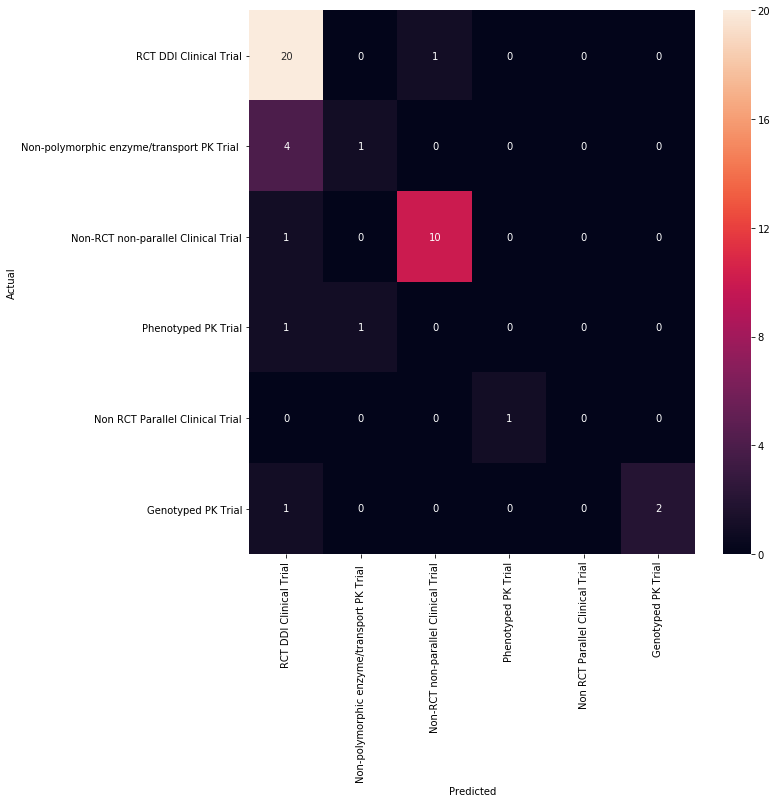

In [10]:
#MULTICLASS CLASSIFIER IMPLEMENTATION
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')

# SVM Model with bigrams taken from Abstract, Article Title, & Methods Section text
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils import class_weight
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from collections import defaultdict
import pickle
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english', ignore_stopwords=False)

class StemmedTfidfVectorizer(TfidfVectorizer):    
    def __init__(self, stemmer, *args, **kwargs):
        super(StemmedTfidfVectorizer, self).__init__(*args, **kwargs)
        self.stemmer = stemmer
        
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (self.stemmer.stem(word) for word in analyzer(doc.replace('\n', ' ')))

###MAIN PROGRAM###
#put labels
labels_level_1 = df.category_id_1
labels_level_2 = df.category_id_2
labels_level_3 = df.category_id_3

#Get tfidf from Title. Abstract, Methods Section
text = df['Abstract'] + df['Article Title'] + df['Methods Section']
tfidf = StemmedTfidfVectorizer(stemmer=stemmer, sublinear_tf=True, ngram_range=(1, 1))
features_fit = tfidf.fit(text)
features = features_fit.transform(text)
labels = df.category_id_3
   
chi_squarer_multiclass = SelectKBest(chi2, k=5000)

#Train multi-class SVM model 
X_train, X_test, y_train, y_test,  = train_test_split(features, labels_level_3, stratify = labels_level_3, test_size=0.2, random_state = 0)
model_multiclass = SVC(kernel='linear', class_weight='balanced')
clf_pipe_multiclass = Pipeline([('chi_sq', chi_squarer_multiclass), ('model', model_multiclass)])
clf_multiclass = clf_pipe_multiclass.fit(X_train, y_train)
predictions_multiclass = clf_multiclass.predict(X_test)

#Print Accurancy, ROC AUC, F1 Scores, Recall, Precision)
print ('Accuracy:', accuracy_score(y_test, predictions_multiclass))
print ('Precision:', precision_score(y_test, predictions_multiclass,average='weighted'))
print ('Recall:', recall_score(y_test, predictions_multiclass,average='weighted'))
print ('F1 score:', f1_score(y_test, predictions_multiclass,average='weighted'))
print (classification_report(y_test,predictions_multiclass))

conf_mat = confusion_matrix(y_test, predictions_multiclass)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_3['Third Label'].values, yticklabels=category_id_df_3['Third Label'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
        
#CHANGE THE PATH TO THE FOLDER WHERE YOU STORE DATA
filename_multiclass_classifier = '/Users/phuong/Documents/JBI_paper/Models/model_multiclass_classifier.sav'
pickle.dump(clf_multiclass, open(filename_multiclass_classifier, 'wb'))

In [17]:
#EVALUATION OF MULTICLASS CLASSIFIER ON UNLABELED DATA
stemmer = SnowballStemmer('english', ignore_stopwords=False)

new_df = pd.read_csv('/Users/phuong/Documents/JBI_paper/Data_files/Main_Data/Unlabeled_Papers_Evaluation.csv',encoding ='latin1')

for index, row in new_df.iterrows():
    final_prediction = ""
    result_level_1 = 10
    result_level_2 = 10
    result_level_3 = 10
    
    PMID = row['PMID']
    new_text = row['Title'] + row['Abstract'] + row['Methods Section']
    new_text=[new_text]
    
    #multiclass classifier prediction
    new_features = tfidf.transform(new_text)
    multiclass_model = pickle.load(open('/Users/phuong/Documents/JBI_paper/Models/model_multiclass_classifier.sav', 'rb'))
    mutlticlass_prediction = multiclass_model.predict(new_features)
    
    if mutlticlass_prediction == 0:
        print (str(PMID) + ": RCT DDI Clinical Trial")
    elif mutlticlass_prediction == 1:
        print (str(PMID) + ": Non-polymorphic enzyme/transport PK Trial")
    elif mutlticlass_prediction == 2:
        print (str(PMID) + ": Non-RCT non-parallel DDI Clinical Trial")
    elif mutlticlass_prediction == 3:
        print (str(PMID) + ": Phenotyped PK Trial")
    elif mutlticlass_prediction == 4:
        print (str(PMID) + ": Non-RCT parallel DDI Clinical Trial")
    elif mutlticlass_prediction == 5:
        print (str(PMID) + ": Genotype PK Trial")
        

16514303: RCT DDI Clinical Trial
19033449: RCT DDI Clinical Trial
10587283: RCT DDI Clinical Trial
21876043: RCT DDI Clinical Trial
23876492: Genotype PK Trial
18408565: Genotype PK Trial
12603176: RCT DDI Clinical Trial
20081064: RCT DDI Clinical Trial
15980690: RCT DDI Clinical Trial
21628604: RCT DDI Clinical Trial
23334403: RCT DDI Clinical Trial
22472994: RCT DDI Clinical Trial
22348256: RCT DDI Clinical Trial
16321618: RCT DDI Clinical Trial
19474787: RCT DDI Clinical Trial
18094221: RCT DDI Clinical Trial
19552746: RCT DDI Clinical Trial
23381840: RCT DDI Clinical Trial
14748817: RCT DDI Clinical Trial
16198652: RCT DDI Clinical Trial
16101667: RCT DDI Clinical Trial
12445025: Non-RCT non-parallel DDI Clinical Trial
16011979: Non-RCT non-parallel DDI Clinical Trial
21822144: Non-RCT non-parallel DDI Clinical Trial
18307374: Non-polymorphic enzyme/transport PK Trial
21895039: Non-polymorphic enzyme/transport PK Trial
17015053: Genotype PK Trial
17121171: Non-RCT non-parallel DDI 